In [1]:
import sys, os, time
import shutil

# %pdb

# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

# plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
# len(dataset)

In [3]:
# dataset = train.get_dataset('transfer', new='nocap-3dshapes', budget=100,
#                             new_kwargs={'dataroot':os.environ['FOUNDATION_DATA_DIR'], 'labels':False})
# len(dataset)

In [4]:
# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0,10,0,10])

# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0, None, 0, 0])


In [5]:
# idx = np.random.randint(len(dataset), size=16)
# idx

In [6]:
# samples = [dataset[i] for i in idx]
# if len(samples[0]) > 1:
#     X, Y = zip(*samples)
#     X = torch.stack(X)
#     Y = torch.stack(Y)
# else:
#     X = torch.stack([s[0] for s in samples])
#     Y = None
# show_nums(X)
# if Y is not None:
#     print(Y.shape)
# else:
#     print(X.shape)

In [7]:
M = Hybrid_Controller().filter_strs('!test')

Found 146 runs
Auto parsing failed with: test-cmd_200129-123106
Auto parsing failed with: test-cmd_200129-181621
Auto parsing failed with: test-cmd_200129-184754
Auto parsing failed with: test-cmd_200129-220436
Auto parsing failed with: test-cmd_200129-220823
Auto parsing failed with: test-cmd_200129-220851
Auto parsing failed with: test-cmd_200129-221006
Auto parsing failed with: test-cmd_200129-223408
Auto parsing failed with: test-cmd_200129-223445
Auto parsing failed with: test-cmd_200129-230209
Auto parsing failed with: test-cmd_200129-230317
Auto parsing failed with: test-cmd_200129-230424
Auto parsing failed with: test-cmd_200129-230534
Auto parsing failed with: test-cmd_200129-230658
Auto parsing failed with: test-cmd_200131-125233
Auto parsing failed with: test-cmd_200131-125639
Auto parsing failed with: test-cmd_200131-131602
Auto parsing failed with: test-cmd_200131-131825
Auto parsing failed with: test-cmd_200131-185027
Auto parsing failed with: test-pycharm_200129-191211
A

In [8]:
M.clear_run_cache()

In [9]:
M.clear_filters().filter_strs('!test')

# M.filter_datasets( 'redball', 'rgbball', '3dshapes')

# M.filter_since(date='200114').filter_data('rgbball')
# M.filter_jobs(157, 158)
# M.filter_jobs(169)
# M.filter_jobs(178)
# M.filter_jobs(174, 175)
# M.filter_models('vae')
# M.filter_jobs(94, 122) # basic models
# M.filter_jobs(100, 102)
# M.filter(lambda r: 'adain-dec' in r.config.info.history)
M.filter_models('fwae')

M.store_selection('all')

M.prep_info()

M.filter_datasets('3dSshape1', )#'3dSshape1s1', '3dSshape1s2')

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' not in r.config)

M.sort_by('date')

M.store_selection('originals')
print('originals', len(M))



M.switch_selection('all')

M.filter_datasets('3dSshape1s1', )

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' in r.config)

M.sort_by('date')

M.store_selection('stage1')

print('stage1', len(M))

M.switch_selection('all')

M.filter_datasets('3dSshape1s1', )

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' not in r.config)

M.sort_by('date')

M.store_selection('ctrl')

print('ctrl', len(M))

# M.load_configs(60)

# M.load_configs(100)

# M.sort_by('job')

Selecting checkpoint: last


/is/ei/fleeb/workspace/foundation/foundation/train/config.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


Loaded configs
originals 1
stage1 2
ctrl 1


In [10]:
group_names = ['originals', 'stage1', 'ctrl']
groups = {}

inds = None
if inds is None:
    inds = [None]*len(group_names)

runs = []

for g, i in zip(group_names, inds):
    M.switch_selection(g)
    if i is None:
        i = 0
    runs.append(M[i])
    groups[g] = M[i]
    runs[-1].stage = g
    print('{}: {}'.format(runs[-1].stage, runs[-1].name))

originals: 3dSshape1-fwae_0002-6026518-12_200129-002149
stage1: 3dSshape1s1-fwae_0016-6035183-02_200129-224937
ctrl: 3dSshape1s1-fwae_0021-6042295-02_200130-130723


In [11]:
# M.load_into('eval.pth.tar')

In [12]:
M.set_active(runs)
M.show('ckpt')

  0) 3dSshape1-fwae_0002-6026518-12_200129-002149
	Checkpoint: 32 (approx 96000 steps)

  1) 3dSshape1s1-fwae_0016-6035183-02_200129-224937
	Checkpoint: 37 (approx 74000 steps)

  2) 3dSshape1s1-fwae_0021-6042295-02_200130-130723
	Checkpoint: 50 (approx 100000 steps)



In [13]:
ref = groups['originals']

In [14]:
# full = trn.get_dataset('3dshapes')

In [123]:
# box = trn.get_dataset('byfactor', counts=[-1,0,0,0])
box = None
cyl = trn.get_dataset('byfactor', counts=[0,2000,0,0])
cyl = fd.data.Subset_Dataset(cyl, np.arange(1000)+600)
# sph = trn.get_dataset('byfactor', counts=[0,0,1600,0])
dataset = cyl

Loading dataset: byfactor
factor: shape (by default)
vals: None (by default)
counts: [0, 2000, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 382000/384000 samples


In [124]:
def _loadrun(run, ref=False):
    
    if 'state' not in run:
    
        state = run.reset()
        
        if not ref:
            state.dataset = dataset

        run.load()

        del state.loader
        del state.batch
        del state.X

        return state
    return run.state

In [125]:
S = _loadrun(ref, ref=True)
box = fd.data.Subset_Dataset(S.valset, np.arange(1000))

In [126]:
Ss = M.map(_loadrun)
len(M)

3

In [127]:
len(box), len(cyl)

(1000, 1000)

In [128]:
border, between = 0.02, 0.01

In [129]:
M[0].config.dataset

{{'batch_size':128, 'counts':[-1, 0, 0, 0], 'drop_last':False, 'factor':'shape', 'name':'byfactor', 'shuffle':True, 'val_split':0.1, '_ipython_canary_method_should_not_exist_':{{}}}}

In [130]:
dataset = cyl

In [131]:
util.set_seed(0)
B = 16
idx = np.random.randint(len(dataset), size=(B,))
idx

array([684, 559, 629, 192, 835, 763, 707, 359,   9, 723, 277, 754, 804, 599,  70, 472])

In [132]:
X, = dataset[idx]
X = X.to('cuda')
B = X.size(0)
X.shape

torch.Size([16, 3, 64, 64])

<IPython.core.display.Javascript object>


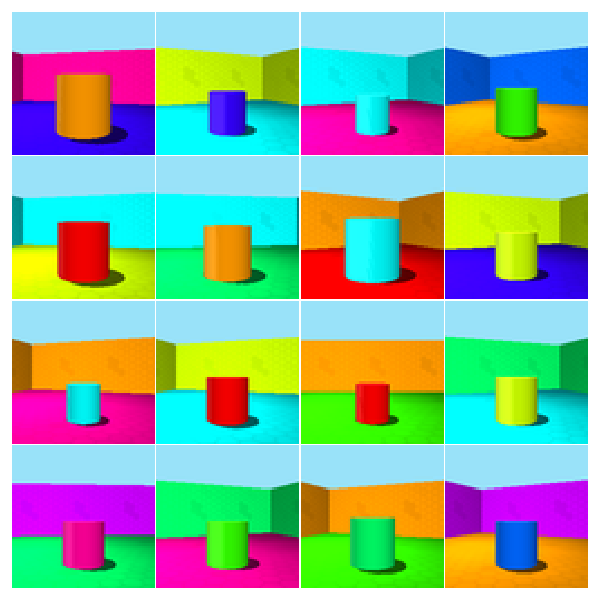

In [133]:
fig = show_nums(X)
plt.subplots_adjust(wspace=between, hspace=between,
	                    left=border, right=1 - border, bottom=border, top=1 - border)
pass

In [134]:
criterion = S.model.criterion
criterion.reduction = 'none'

In [135]:

def _fn(run):
    s = run.state
    
    Q = []
    L = []
    R = []
    
    batch_size = 200
    
    loader = trn.get_loaders(dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        
        q = s.model.encode(X)
        if isinstance(q, distrib.Distribution):
            q = q.mu
        s.rec = s.model.decode(q)
        s.q = q
        
        for batch in loader:
            batch = util.to(batch, s.A.device)
            x = batch[0]
            
            q = s.model.encode(x)
            
            if isinstance(q, distrib.Distribution):
                q = q.mu
            Q.append(q)
            
            rec = s.model.decode(q)
            
            loss = criterion(x, rec)
            loss = loss.view(batch_size,-1).sum(-1)
            
            R.append(rec)
            L.append(loss)
        
        Q = torch.cat(Q).cpu()
        L = torch.cat(L).cpu().view(-1)
        R = torch.cat(R).cpu()
        
        
        s.Q = Q
        s.L = L
        s.R = R
        
#     return s.rec

M.map(_fn)
pass

Using batched data loader
Using batched data loader
Using batched data loader


<IPython.core.display.Javascript object>


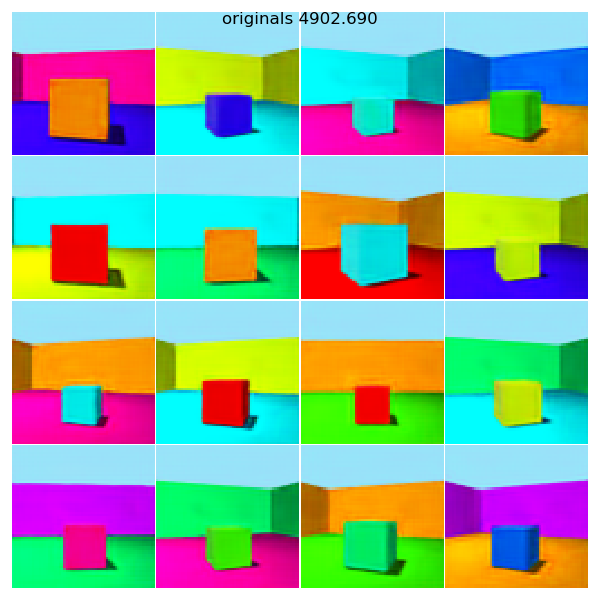

<IPython.core.display.Javascript object>


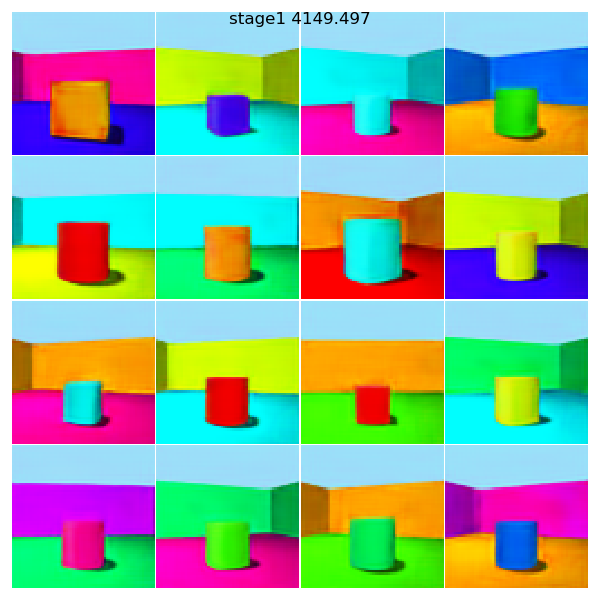

<IPython.core.display.Javascript object>


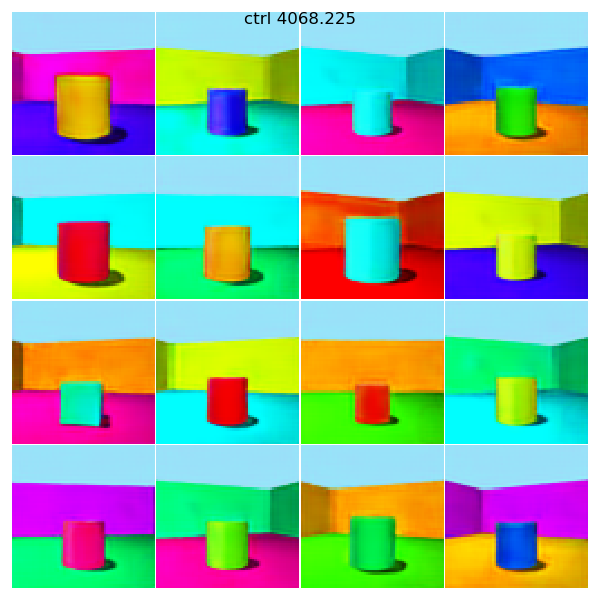

In [136]:
def _fn(run):
    s = run.state
    fig = show_nums(s.rec)
    fig.suptitle('{} {:.3f}'.format(run.stage, s.L.mean().item()))
    plt.subplots_adjust(wspace=between, hspace=between,
                            left=border, right=1 - border, bottom=border, top=1 - border)
    return fig
figs = M.map(_fn)

In [117]:
data = {}
for r in M:
    data[r.stage] = r.state.L.numpy()
    print(data[r.stage].max())

9898.107
6028.9307
16049.301


In [137]:
df = pd.DataFrame({r.stage:r.state.L.numpy() for r in M})

In [138]:
r.state.L.numpy().max()

13997.037

In [139]:
df = pd.melt(df, id_vars=None, var_name='cat', value_name='val')

In [140]:
hue = None
split = False
color = 'C0'
inner = 'box'
palette = None

<IPython.core.display.Javascript object>


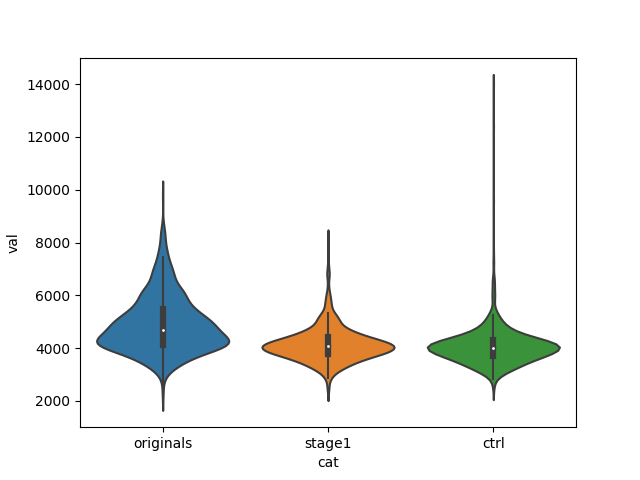

In [141]:
plt.figure()
sns.violinplot(x='cat', y='val', # color=color,
		               data=df, split=split, palette=palette,
		               scale="count", inner=inner, gridsize=100,)
pass

In [97]:
s = M[1].state

In [98]:
s.R.shape

torch.Size([1000, 3, 64, 64])

In [99]:
s.L.shape

torch.Size([1000])

In [100]:
s.L.max(0)

torch.return_types.max(
values=tensor(19978.5195),
indices=tensor(418))

In [101]:
len(dataset)

1000

In [102]:
o = 418

In [103]:
s.L[o-2:o+2]

tensor([ 4315.7998,  4038.1104, 19978.5195,  4070.2913])

<IPython.core.display.Javascript object>


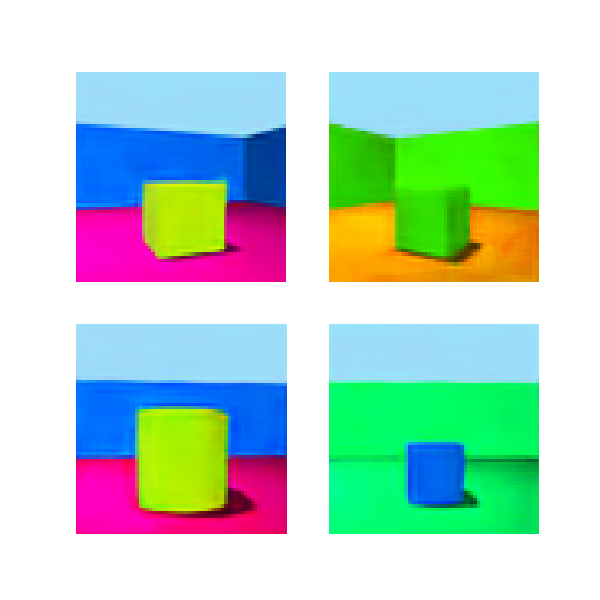

In [104]:
show_nums(s.R[o-2:o+2])
pass

<IPython.core.display.Javascript object>


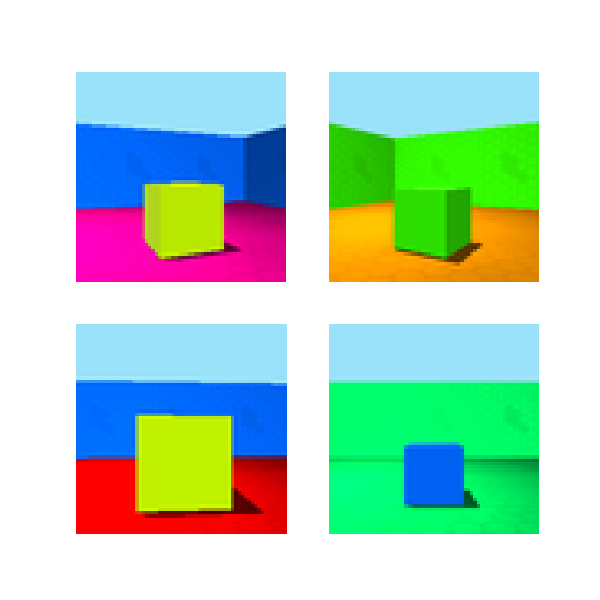

In [105]:
show_nums(dataset[o-2:o+2][0])
pass